1 - bibliotecas

In [65]:
import os
import zipfile
import cv2
import random
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import (
     Flatten, Dropout, Dense, LSTM, Bidirectional, TimeDistributed, Input
)

2 - download do dataset

In [ ]:
if not os.path.exists("content"):
    os.makedirs("content")

os.system('kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset -p content')

zip_path = "content/real-life-violence-situations-dataset.zip"
if os.path.exists(zip_path):

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("content")
    print("Arquivo descompactado com sucesso!")
else:
    print("Arquivo ZIP não encontrado!")

2.1 - organização das pastas

In [ ]:
pastas = {
    "content/Real Life Violence Dataset": "content/train"
}

for antiga, nova in pastas.items():
    if os.path.exists(antiga):
        os.rename(antiga, nova)
        print(f"Renomeado: {antiga} -> {nova}")
    else:
        print(f"Erro: A pasta '{antiga}' não existe.")

Erro: A pasta 'content/files/aggressive' não existe.


3 - configuração do dataset

In [66]:
DATASET_DIR = "content/train"
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16
CLASSES_LIST = ["NonViolence","Violence"]
arrayDir = "array"

4 - função de extração dos frames

In [67]:
def frames_extraction(video_path):
 
    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)
 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    for frame_counter in range(SEQUENCE_LENGTH):
 
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
    
 
    video_reader.release()
 
    return frames_list

5 - função de criação do dataset

In [68]:
def create_dataset():
 
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            frames = frames_extraction(video_file_path)
 
            if len(frames) == SEQUENCE_LENGTH:
 
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths

6 - salvamento dos arrays

In [69]:
if not os.path.exists("array"):
    os.makedirs("array")

features, labels, video_files_paths = create_dataset()

np.save(os.path.join(arrayDir, "features.npy"), features)
np.save(os.path.join(arrayDir, "labels.npy"), labels)
np.save(os.path.join(arrayDir, "video_files_paths.npy"), video_files_paths)

Extracting Data of Class: NonViolence
Extracting Data of Class: Violence


6.2 - load dos arrays

In [70]:
features, labels, video_files_paths = np.load(os.path.join(arrayDir, "features.npy")), \
                                      np.load(os.path.join(arrayDir, "labels.npy")), \
                                      np.load(os.path.join(arrayDir, "video_files_paths.npy"))

7 - one-hot

In [71]:
one_hot_encoded_labels = to_categorical(labels)

8 - organização dos datasets em 90% treino e 10% validação

In [72]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(1800, 16, 64, 64, 3) (1800, 2)
(200, 16, 64, 64, 3) (200, 2)


9 - MobileNetV2 com treino de até 40 camadas

In [73]:
mobilenet = MobileNetV2( include_top=False , weights="imagenet")

mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[

10 - MobileNetV2 + Bi-LSTM

In [74]:
def create_model():
 
    model = Sequential()
    
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(mobilenet))
    
    model.add(Dropout(0.25))
                                    
    model.add(TimeDistributed(Flatten()))

    
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)  

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    
    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(len(CLASSES_LIST), activation = 'sigmoid'))#softmax
 
    model.summary()
    
    return model

10.1 info e criação do modelo

In [ ]:
MoBiLSTM_model = create_model()
plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, 16, 2, 2, 1280)    2257984   
 stributed)                                                      
                                                                 
 dropout_12 (Dropout)        (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_5 (TimeDi  (None, 16, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                1319168   
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                      

11 - callback e parada de treino

In [76]:
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)

12 - compilação do modelo

In [ ]:
MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer ='sgd', metrics = ["accuracy"])

13 - treino

In [78]:
MobBiLSTM_model_history = MoBiLSTM_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 64,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
23/23 [==============================] - 58s 2s/step - loss: 0.7048 - accuracy: 0.5076 - val_loss: 0.7046 - val_accuracy: 0.4500 - lr: 0.0100
Epoch 2/50
23/23 [==============================] - 41s 2s/step - loss: 0.6981 - accuracy: 0.5181 - val_loss: 0.6977 - val_accuracy: 0.4806 - lr: 0.0100
Epoch 3/50
23/23 [==============================] - 41s 2s/step - loss: 0.6890 - accuracy: 0.5271 - val_loss: 0.6925 - val_accuracy: 0.5028 - lr: 0.0100
Epoch 4/50
23/23 [==============================] - 41s 2s/step - loss: 0.6810 - accuracy: 0.5611 - val_loss: 0.6891 - val_accuracy: 0.5333 - lr: 0.0100
Epoch 5/50
23/23 [==============================] - 41s 2s/step - loss: 0.6791 - accuracy: 0.5653 - val_loss: 0.6842 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 6/50
23/23 [==============================] - 39s 2s/step - loss: 0.6697 - accuracy: 0.5799 - val_loss: 0.6800 - val_accuracy: 0.6139 - lr: 0.0100
Epoch 7/50
23/23 [==============================] - 39s 2s/step - loss: 0.6683 - a

14 - validação

In [79]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

7/7 [==============================] - 2s 215ms/step - loss: 0.3429 - accuracy: 0.9150


14.2 - função de graficos de validação

In [80]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

14.3 - graficos

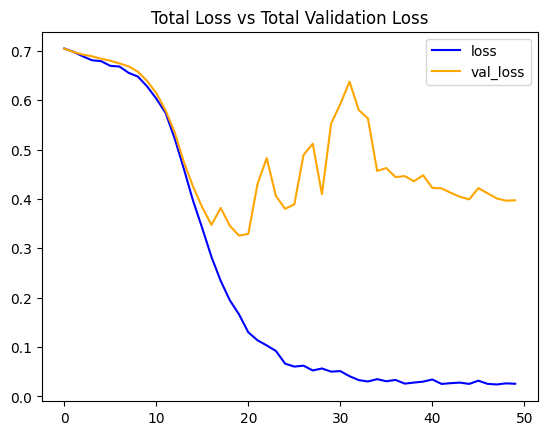

In [81]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

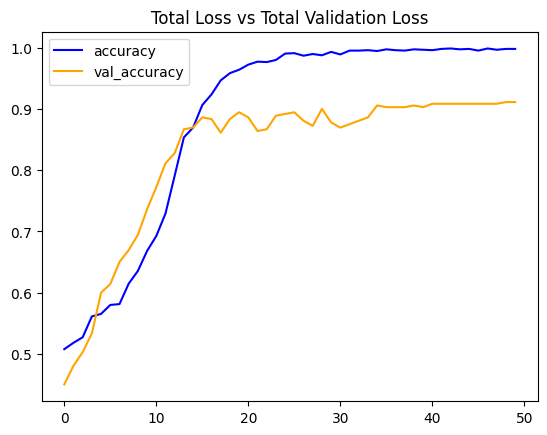

In [82]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

15 - matriz de confusão

7/7 [==============================] - 5s 202ms/step
Accuracy Score is :  0.915
Classification Report is : 
               precision    recall  f1-score   support

           0       0.89      0.95      0.92        99
           1       0.95      0.88      0.91       101

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200



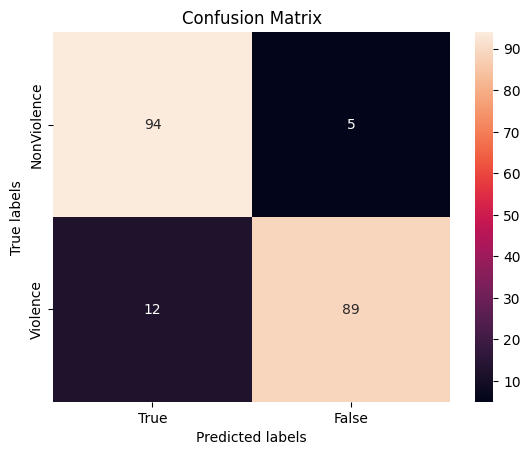

In [83]:
labels_predict = MoBiLSTM_model.predict(features_test)

labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

labels_test_normal.shape , labels_predict.shape

from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

import seaborn as sns 
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

16 - função de predição por frames

In [84]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    predicted_class_name = ''

    while video_reader.isOpened():
 
        ok, frame = video_reader.read() 
        
        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255
 
        frames_queue.append(normalized_frame)
 
        if len(frames_queue) == SEQUENCE_LENGTH:                        

            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]

        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)
         
        video_writer.write(frame)                       
        
    video_reader.release()
    video_writer.release()

17 - função de exibição de predição por frames

In [85]:
plt.style.use("default")

def show_pred_frames(pred_video_path): 

    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)

    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    random_range = sorted(random.sample(range (SEQUENCE_LENGTH , frames_count ), 12))
        
    for counter, random_index in enumerate(random_range, 1):
        
        plt.subplot(5, 4, counter)
 
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
          
        ok, frame = video_reader.read() 

        if not ok:
          break 

        frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

        plt.imshow(frame);ax.figure.set_size_inches(20,20);plt.tight_layout()
                            
    video_reader.release()

18 - criação da pasta de video a ser analisado

In [86]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)
 
output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

18.1 - video a ser analisado

In [87]:
input_video_file_path = "content/train/Violence/V_5.mp4"

19 - teste por frame

1/1 [==============================] - 0s 89ms/step


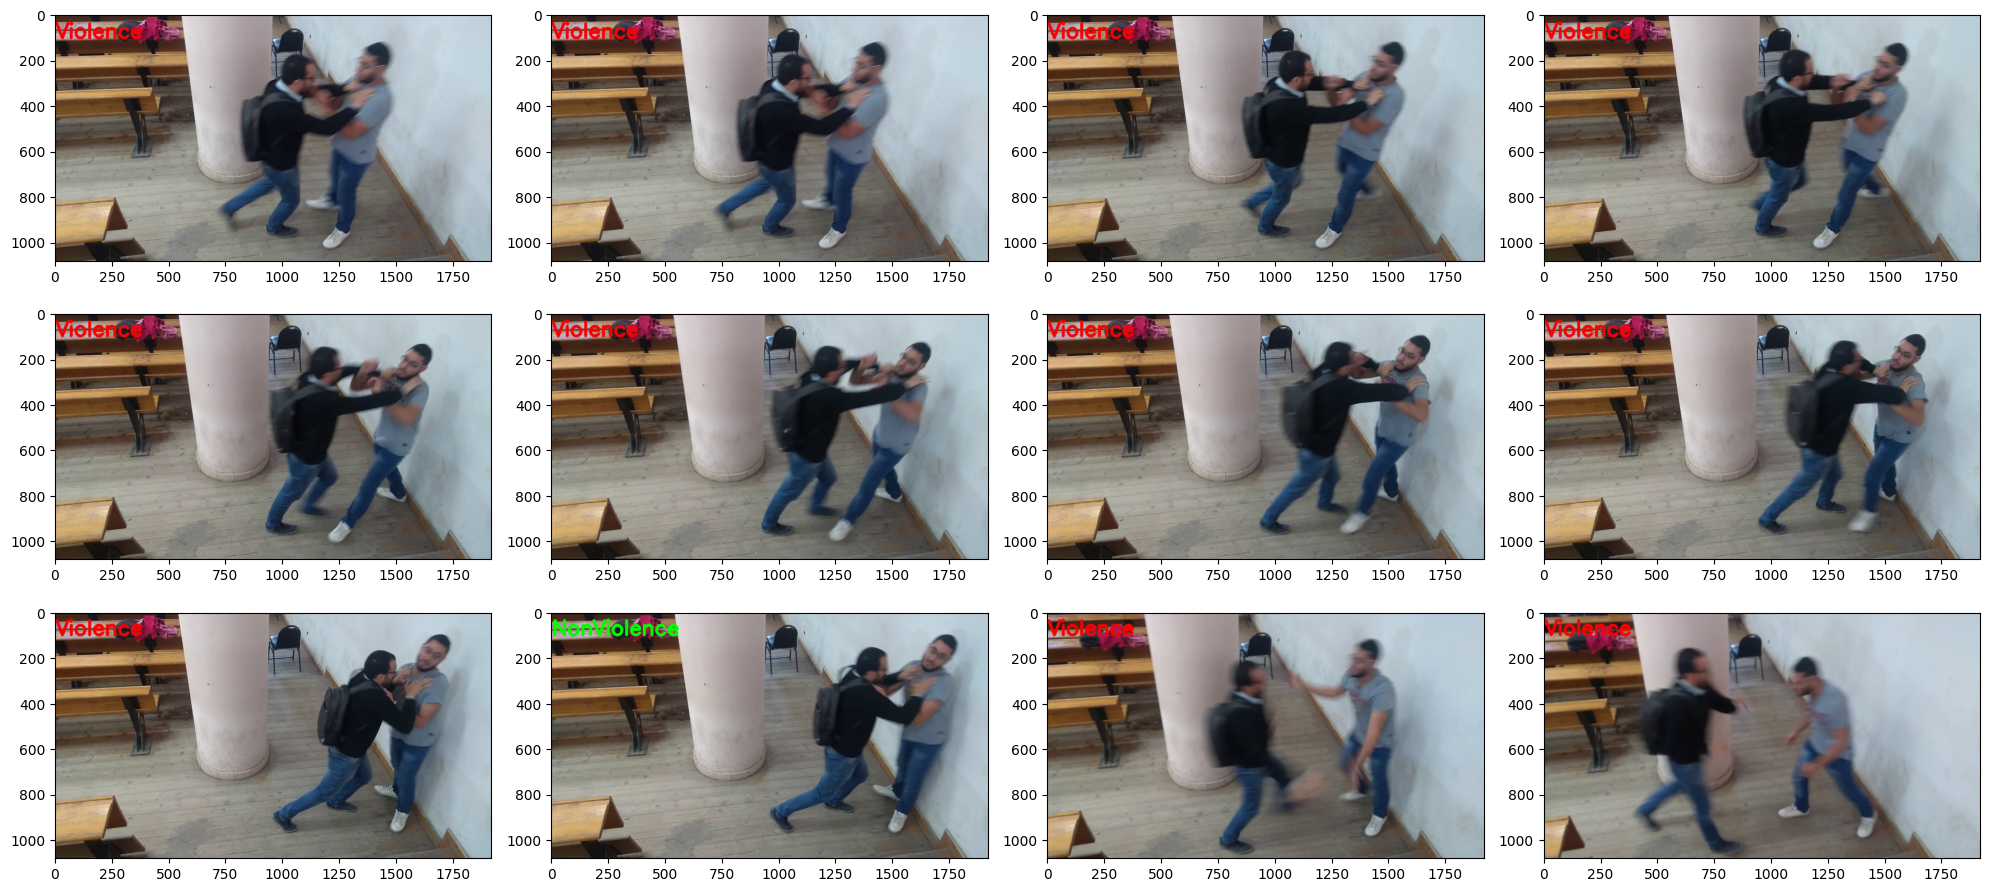

In [88]:
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

show_pred_frames(output_video_file_path)

20 - função de predição por video

In [89]:
def predict_video(video_file_path, SEQUENCE_LENGTH):
 
    video_reader = cv2.VideoCapture(video_file_path)
 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames_list = []
    
    predicted_class_name = ''
 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):
 
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)

        predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
        predicted_label = np.argmax(predicted_labels_probabilities)
 
        predicted_class_name = CLASSES_LIST[predicted_label]
    
        print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
        video_reader.release()


21 - resultado final!

In [ ]:
predict_video(input_video_file_path, SEQUENCE_LENGTH)
#Play_Video(input_video_file_path)

#https://www.kaggle.com/datasets/rohitcode123/violence-dataset/data

1/1 [==============================] - 6s 6s/step
Predicted: Violence
Confidence: 0.8224131464958191
